<a href="https://colab.research.google.com/github/Keita062/soccer/blob/main/11_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [7]:
premia = pd.read_csv('premia.csv')

In [8]:
premia['Date'] = pd.to_datetime(premia['Date'])

In [10]:
# チーム名のラベルエンコーディング
le_team = LabelEncoder()
premia['Home_Team'] = le_team.fit_transform(premia['Home_Team'])
premia['Awey_Team'] = le_team.fit_transform(premia['Awey_Team'])

In [15]:
print(premia['Home_Team'].unique())
print(premia['Awey_Team'].unique())

[ 1 23 14 22 16 39 13 36 18 31 26  5 50 38 30 27 25 28 32  2 44 34 29 48
 43 24  7 17 41  3 12 45  8 19 47  4 33 51 49 35 21 40 10  6 42 11  0  9
 20 15 46 37]
[30 50 28  2  5 44 32 27 38 25 34  1 22 31 13 18 36 26 16 23 14 39 43 48
 29 24  7 41 17  3 12  8 45 19 47  4 51 33 49 35 40 21 10  6 42 11  0 20
  9 46 15 37]


In [16]:
# 年のカラムを作成
premia['Year'] = premia['Date'].dt.year
premia["Mounth"] = premia["Date"].dt.month
premia["Day"] = premia["Date"].dt.day

In [18]:
# 2020年までを訓練データ、2021年をテストデータとする
train = premia[premia['Year'] < 2021]
test = premia[premia['Year'] == 2021]

In [19]:
# 特徴量と目的変数の設定
X_train = train[['Home_Team', 'Awey_Team', 'Section']]
y_train = train[['Home_Score', 'Awey_Score']]

X_test = test[['Home_Team', 'Awey_Team', 'Section']]
y_test = test[['Home_Score', 'Awey_Score']]

In [20]:
# ホームスコア用モデル
model_home = RandomForestRegressor()
model_home.fit(X_train, y_train['Home_Score'])

RandomForestRegressor()

In [21]:
# アウェイスコア用モデル
model_awey = RandomForestRegressor()
model_awey.fit(X_train, y_train['Awey_Score'])

RandomForestRegressor()

In [22]:
# スコアの予測
y_pred_home = model_home.predict(X_test)
y_pred_awey = model_awey.predict(X_test)

In [23]:
# 評価
mse_home = mean_squared_error(y_test['Home_Score'], y_pred_home)
mse_awey = mean_squared_error(y_test['Awey_Score'], y_pred_awey)

In [24]:
print("Home Score MSE:", mse_home)
print("Awey Score MSE:", mse_awey)

Home Score MSE: 2.0338819664389187
Awey Score MSE: 1.693537284089827


In [25]:
# 結果の確認
results = test[['Date', 'Home_Team', 'Awey_Team']].copy()
results['Actual_Home_Score'] = y_test['Home_Score'].values
results['Predicted_Home_Score'] = y_pred_home
results['Actual_Awey_Score'] = y_test['Awey_Score'].values
results['Predicted_Awey_Score'] = y_pred_awey

# チーム名をもとに戻す（逆変換）
results['Home_Team'] = le_team.inverse_transform(results['Home_Team'])
results['Awey_Team'] = le_team.inverse_transform(results['Awey_Team'])

In [27]:
results.head()

,Date,Home_Team,Awey_Team,Actual_Home_Score,Predicted_Home_Score,Actual_Awey_Score,Predicted_Awey_Score
10661,2021-01-01,Everton,West Ham United,0,2.290000,1,0.180000
10662,2021-01-01,Manchester United,Aston Villa,2,1.375833,1,0.876667
10663,2021-01-02,Tottenham Hotspur,Leeds United,3,1.723000,0,1.225833
10664,2021-01-02,Crystal Palace,Sheffield Utd,2,1.084667,0,0.750000
10665,2021-01-02,Brighton,Wolves,3,2.173333,3,1.160000


In [32]:
import pandas as pd

def calculate_detailed_stats(results):
    stats = {}

    for index, row in results.iterrows():
        home_team = row['Home_Team']
        away_team = row['Awey_Team']
        actual_home_score = row['Actual_Home_Score']
        actual_awey_score = row['Actual_Awey_Score']

        # ホームチームの統計計算
        if home_team not in stats:
            stats[home_team] = {
                'Matches': 0,
                'Wins': 0,
                'Draws': 0,
                'Losses': 0,
                'Goals_For': 0,
                'Goals_Against': 0,
                'Points': 0,
            }

        # アウェイチームの統計計算
        if away_team not in stats:
            stats[away_team] = {
                'Matches': 0,
                'Wins': 0,
                'Draws': 0,
                'Losses': 0,
                'Goals_For': 0,
                'Goals_Against': 0,
                'Points': 0,
            }

        # 試合数の更新
        stats[home_team]['Matches'] += 1
        stats[away_team]['Matches'] += 1

        # 得点と失点の更新
        stats[home_team]['Goals_For'] += actual_home_score
        stats[home_team]['Goals_Against'] += actual_awey_score
        stats[away_team]['Goals_For'] += actual_awey_score
        stats[away_team]['Goals_Against'] += actual_home_score

        # 勝敗の更新
        if actual_home_score > actual_awey_score:
            stats[home_team]['Wins'] += 1
            stats[away_team]['Losses'] += 1
            stats[home_team]['Points'] += 3
        elif actual_home_score < actual_awey_score:
            stats[away_team]['Wins'] += 1
            stats[home_team]['Losses'] += 1
            stats[away_team]['Points'] += 3
        else:
            stats[home_team]['Draws'] += 1
            stats[away_team]['Draws'] += 1
            stats[home_team]['Points'] += 1
            stats[away_team]['Points'] += 1

    # DataFrameに変換
    standings = []
    for team, stat in stats.items():
        stat['Team'] = team
        stat['Goal_Difference'] = stat['Goals_For'] - stat['Goals_Against']
        standings.append(stat)

    return pd.DataFrame(standings).sort_values(by='Points', ascending=False)

# 実際のスコアからの順位表を作成
actual_standings = calculate_detailed_stats(results)

# 予測スコアからの順位表を作成するための関数を定義
def calculate_detailed_predicted_stats(results):
    stats = {}

    for index, row in results.iterrows():
        home_team = row['Home_Team']
        away_team = row['Awey_Team']
        predicted_home_score = row['Predicted_Home_Score']
        predicted_awey_score = row['Predicted_Awey_Score']

        # ホームチームの統計計算
        if home_team not in stats:
            stats[home_team] = {
                'Matches': 0,
                'Wins': 0,
                'Draws': 0,
                'Losses': 0,
                'Goals_For': 0,
                'Goals_Against': 0,
                'Points': 0,
            }

        # アウェイチームの統計計算
        if away_team not in stats:
            stats[away_team] = {
                'Matches': 0,
                'Wins': 0,
                'Draws': 0,
                'Losses': 0,
                'Goals_For': 0,
                'Goals_Against': 0,
                'Points': 0,
            }

        # 試合数の更新
        stats[home_team]['Matches'] += 1
        stats[away_team]['Matches'] += 1

        # 得点と失点の更新
        stats[home_team]['Goals_For'] += predicted_home_score
        stats[home_team]['Goals_Against'] += predicted_awey_score
        stats[away_team]['Goals_For'] += predicted_awey_score
        stats[away_team]['Goals_Against'] += predicted_home_score

        # 勝敗の更新
        if predicted_home_score > predicted_awey_score:
            stats[home_team]['Wins'] += 1
            stats[away_team]['Losses'] += 1
            stats[home_team]['Points'] += 3
        elif predicted_home_score < predicted_awey_score:
            stats[away_team]['Wins'] += 1
            stats[home_team]['Losses'] += 1
            stats[away_team]['Points'] += 3
        else:
            stats[home_team]['Draws'] += 1
            stats[away_team]['Draws'] += 1
            stats[home_team]['Points'] += 1
            stats[away_team]['Points'] += 1

    # DataFrameに変換
    standings = []
    for team, stat in stats.items():
        stat['Team'] = team
        stat['Goal_Difference'] = stat['Goals_For'] - stat['Goals_Against']
        standings.append(stat)

    return pd.DataFrame(standings).sort_values(by='Points', ascending=False)

# 予測スコアからの順位表を作成
predicted_standings = calculate_detailed_predicted_stats(results)

In [36]:
# 結果の表示
actual_standings = actual_standings.reindex(columns=['Team', 'Matches', 'Wins', 'Draws', 'Losses', 'Goals_For', 'Goals_Against', 'Goal_Difference', 'Points'])
print("Actual Standings:")
actual_standings


Actual Standings:


,Team,Matches,Wins,Draws,Losses,Goals_For,Goals_Against,Goal_Difference,Points
15,Manchester City,22,18,0,4,57,19,38,54
1,West Ham United,22,13,3,6,39,26,13,42
2,Manchester United,21,11,8,2,39,17,22,41
11,Arsenal,22,12,5,5,39,20,19,41
14,Chelsea,22,12,5,5,27,18,9,41
13,Leicester City,22,11,4,7,39,30,9,37
5,Leeds United,21,10,3,8,29,24,5,33
17,Liverpool,21,10,3,8,27,20,7,33
0,Everton,21,8,5,8,20,26,-6,29
4,Tottenham Hotspur,20,9,2,9,37,28,9,29


In [39]:
predicted_standings = predicted_standings.reindex(columns=['Team', 'Matches', 'Wins', 'Draws', 'Losses', 'Goals_For', 'Goals_Against', 'Goal_Difference', 'Points'])
print("\nPredicted Standings:")
predicted_standings


Predicted Standings:


,Team,Matches,Wins,Draws,Losses,Goals_For,Goals_Against,Goal_Difference,Points
17,Liverpool,21,18,0,3,43.251619,23.828298,19.423321,54
11,Arsenal,22,17,0,5,35.602262,17.056333,18.545929,51
15,Manchester City,22,16,0,6,39.821754,25.731464,14.090290,48
2,Manchester United,21,16,0,5,35.296452,19.051119,16.245333,48
14,Chelsea,22,15,0,7,36.603869,21.821337,14.782532,45
13,Leicester City,22,13,0,9,33.884833,30.559500,3.325333,39
12,Newcastle United,22,12,0,10,34.406250,34.911786,-0.505536,36
5,Leeds United,21,11,0,10,27.061571,25.870063,1.191508,33
0,Everton,21,10,0,11,28.561357,31.816401,-3.255044,30
4,Tottenham Hotspur,20,10,0,10,28.814417,28.923667,-0.109250,30


In [40]:
test

,Section,Date,Home_Team,Awey_Team,Home_Score,Awey_Score,Year,Mounth,Day
10661,17,2021-01-01,18,48,0,1,2021,1,1
10662,17,2021-01-01,27,2,2,1,2021,1,1
10663,17,2021-01-02,44,23,3,0,2021,1,2
10664,17,2021-01-02,15,37,2,0,2021,1,2
10665,17,2021-01-02,9,51,3,3,2021,1,2
...,...,...,...,...,...,...,...,...,...
10869,38,2021-05-23,48,39,3,0,2021,5,23
10870,38,2021-05-23,23,46,3,1,2021,5,23
10871,38,2021-05-23,1,9,2,0,2021,5,23
10872,38,2021-05-23,25,15,2,0,2021,5,23


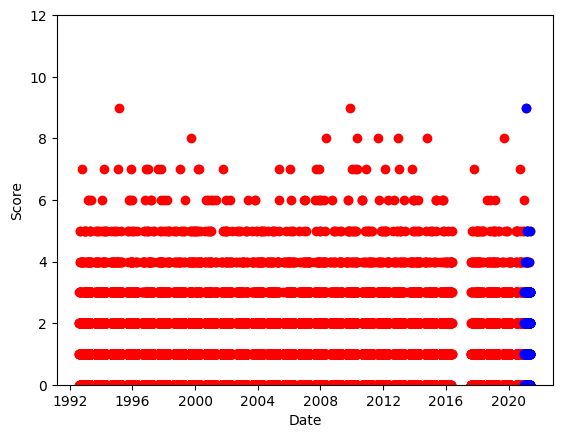

In [42]:
x = premia["Date"]
x2 = test["Date"]
y = premia['Home_Score']
y2 = test['Home_Score']

plt.scatter(x,y,color='red')
plt.scatter(x2,y2,color='blue')
plt.xlabel('Date')
plt.ylabel('Score')

plt.ylim(0,12)

plt.show()

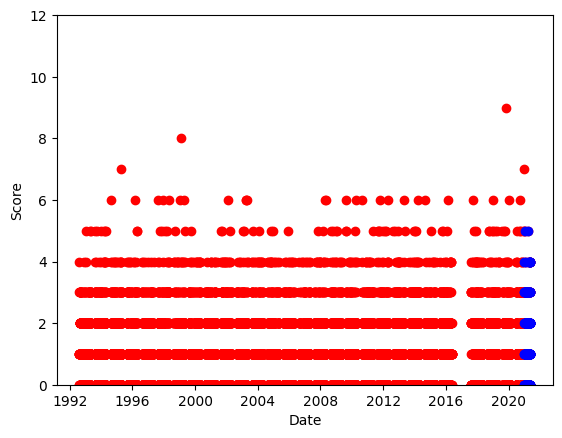

In [43]:
x = premia["Date"]
x2 = test["Date"]
y = premia['Awey_Score']
y2 = test['Awey_Score']

plt.scatter(x,y,color='red')
plt.scatter(x2,y2,color='blue')
plt.xlabel('Date')
plt.ylabel('Score')

plt.ylim(0,12)

plt.show()

In [ ]:
premia.groupby["Home_Score"]